# Титаник. Кто выживет?

https://www.kaggle.com/c/titanic/

In [997]:
import numpy as np
import pandas as pd

In [998]:
import pylab
from skimage.io import imread

In [999]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (15, 10)

In [1000]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score

### Данные

In [1001]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1002]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1003]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1004]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [1005]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [1006]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [1007]:
train['is_test'] = 0
test['is_test'] = 1

In [1008]:
df = pd.concat([train, test])

супер, теперь полный набор данных можно обрабатывать вместе и в любой момент, уже обработанными, обратно разъединить на обучающую и тестовую выборки

Пол male/female закодируем в 1/0 и удалим переменные, с которыми мы не будем сейчас работать

In [1009]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

признаки, значения которых составляют небольшой перечислимый набор, закодируем в отдельные столбцы 

In [1010]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [1011]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [1012]:
df_dummies.head(10)

,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,0,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,0,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,0,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,0,1,0,1,0,0


In [1013]:
df_dummies.isnull().sum()

Age           263
SibSp           0
Parch           0
Fare            1
is_test         0
isMale          0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [1014]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [1015]:
columns = X_train.columns

In [1016]:
X_train.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,1,0,1,0,0


### Заполнение пустых значений

заполним пустые значения средними по соответственным признакам

In [1017]:
from sklearn.preprocessing import Imputer

In [1018]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [1019]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [1020]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [1021]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Нормировка значений

In [1022]:
from sklearn.preprocessing import StandardScaler

In [1023]:
scaler = StandardScaler()

In [1024]:
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1025]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [1026]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

эти номера кластеров можно было бы подать как ещё одна фича

### Разделение на обучающую и тестирующую выборки

In [1027]:
from sklearn.model_selection import train_test_split

In [1028]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

### Обучение с кросс-валидацией

кросс-валидация поможет нам подобрать лучший параметр регуляризации

## Домашнее задание

In [1029]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [1030]:
#DecisionTreeClassifier?

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

In [1031]:
grid = {'max_depth': np.arange(3,10),'min_samples_leaf':np.arange(3,10)}

In [1032]:
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy',cv=5)
gridsearch.fit(X_train_fin, y_train_fin)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [1033]:
sorted(zip(gridsearch.cv_results_['mean_test_score'], gridsearch.cv_results_['params']), key = lambda x: -x[0])

[(0.8286516853932584, {'max_depth': 6, 'min_samples_leaf': 8}),
 (0.827247191011236, {'max_depth': 6, 'min_samples_leaf': 9}),
 (0.827247191011236, {'max_depth': 7, 'min_samples_leaf': 8}),
 (0.8258426966292135, {'max_depth': 8, 'min_samples_leaf': 8}),
 (0.8258426966292135, {'max_depth': 9, 'min_samples_leaf': 8}),
 (0.824438202247191, {'max_depth': 7, 'min_samples_leaf': 9}),
 (0.824438202247191, {'max_depth': 8, 'min_samples_leaf': 9}),
 (0.824438202247191, {'max_depth': 9, 'min_samples_leaf': 9}),
 (0.8230337078651685, {'max_depth': 3, 'min_samples_leaf': 6}),
 (0.8230337078651685, {'max_depth': 3, 'min_samples_leaf': 7}),
 (0.8230337078651685, {'max_depth': 6, 'min_samples_leaf': 5}),
 (0.8230337078651685, {'max_depth': 8, 'min_samples_leaf': 3}),
 (0.8216292134831461, {'max_depth': 3, 'min_samples_leaf': 8}),
 (0.8202247191011236, {'max_depth': 6, 'min_samples_leaf': 7}),
 (0.8188202247191011, {'max_depth': 3, 'min_samples_leaf': 3}),
 (0.8188202247191011, {'max_depth': 3, 'min_s

In [1034]:
# вывести табличку со всеми параметрами
#pd.DataFrame(gridsearch.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [1035]:
gridsearch.best_params_

{'max_depth': 6, 'min_samples_leaf': 8}

In [1036]:
best_max_depth = gridsearch.best_params_["max_depth"]
best_min_samples_leaf = gridsearch.best_params_["min_samples_leaf"]

# Оценка точности

In [1037]:
from sklearn.metrics import accuracy_score

In [1038]:
clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf = best_min_samples_leaf)

In [1039]:
clf.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [1040]:
y_val_pred = clf.predict(X_val)

In [1041]:
accuracy_score(y_val, y_val_pred)

0.7932960893854749

# Финальное предсказание

In [1042]:
clf.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

предсказание номера класса:

In [1043]:
predictions = clf.predict(X_test_imputed_scaled)

In [1044]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

In [1045]:
with open('submission.csv', 'w') as file:
    file.write(submussion)

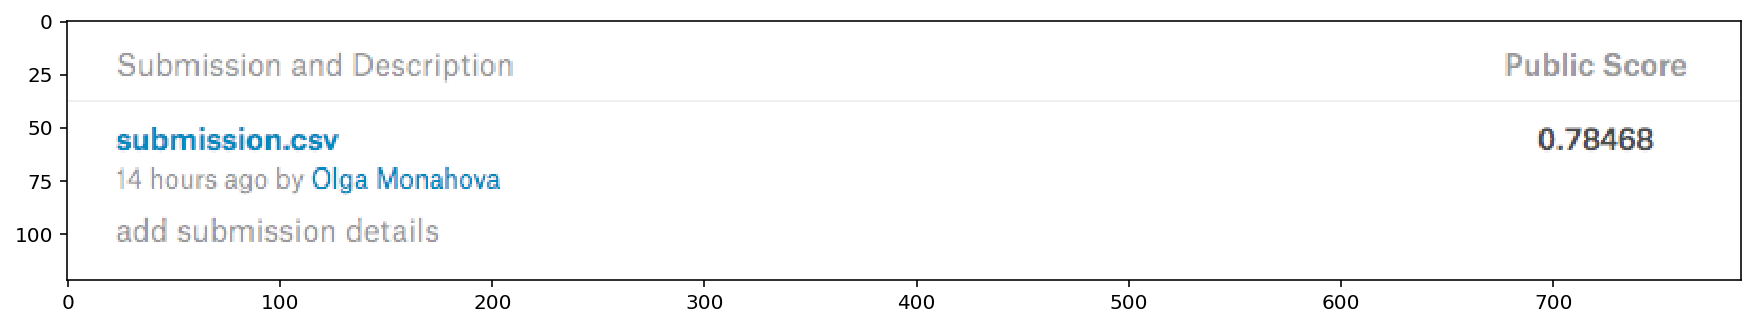

In [1046]:
# инфо с Kaggle
image = imread('submission Kaggle.png')
pylab.imshow(image)

In [1047]:
# расчет метрик точности
# recall низкий, только 67% из всех выживших найдены
roc_auc_train = np.round(roc_auc_score(y_val, y_val_pred), 2)
accuracy = np.round(accuracy_score(y_val, y_val_pred), 2)
f1 = np.round(f1_score(y_val, y_val_pred),2)
presicion = np.round(precision_score(y_val, y_val_pred),2)
recall = np.round(recall_score(y_val, y_val_pred),2)

print("Val score: ", roc_auc_train)
print("Accuracy:" , accuracy)
print("F1-score:" , f1)
print("Precision_score:" , presicion)
print("Recall_score:" , recall)

Val score:  0.78
Accuracy: 0.79
F1-score: 0.74
Precision_score: 0.83
Recall_score: 0.67


Визуализируем дерево

In [1048]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [1049]:
# обратная трансформация в исходные значения
X_val_tr = scaler.inverse_transform(X_val)
X_val_tr = pd.DataFrame(X_val_tr, columns=columns)

In [1050]:
get_tree_dot_view(clf, list(X_val.columns), ['die','survive'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="isMale <= -0.309\ngini = 0.467\nsamples = 712\nvalue = [448, 264]\nclass = die", fillcolor="#e5813969"] ;
1 [label="Pclass_3 <= -0.103\ngini = 0.4\nsamples = 250\nvalue = [69, 181]\nclass = survive", fillcolor="#399de59e"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Fare <= -0.067\ngini = 0.114\nsamples = 132\nvalue = [8, 124]\nclass = survive", fillcolor="#399de5ef"] ;
1 -> 2 ;
3 [label="Age <= 1.024\ngini = 0.191\nsamples = 56\nvalue = [6, 50]\nclass = survive", fillcolor="#399de5e0"] ;
2 -> 3 ;
4 [label="Age <= -0.169\ngini = 0.127\nsamples = 44\nvalue = [3, 41]\nclass = survive", fillcolor="#399de5ec"] ;
3 -> 4 ;
5 [label="Age <= -0.554\ngini = 0.236\nsamples = 22\nvalue = [3, 19]\nclass = survive", fillcolor="#399de5d7"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 13\nvalue = [0, 13]\nclass = survive", fillcolor="#399de5ff"] ;
5 -> 6 ;
7 [label="gini = 0.444\nsamples = 9\nvalue 

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

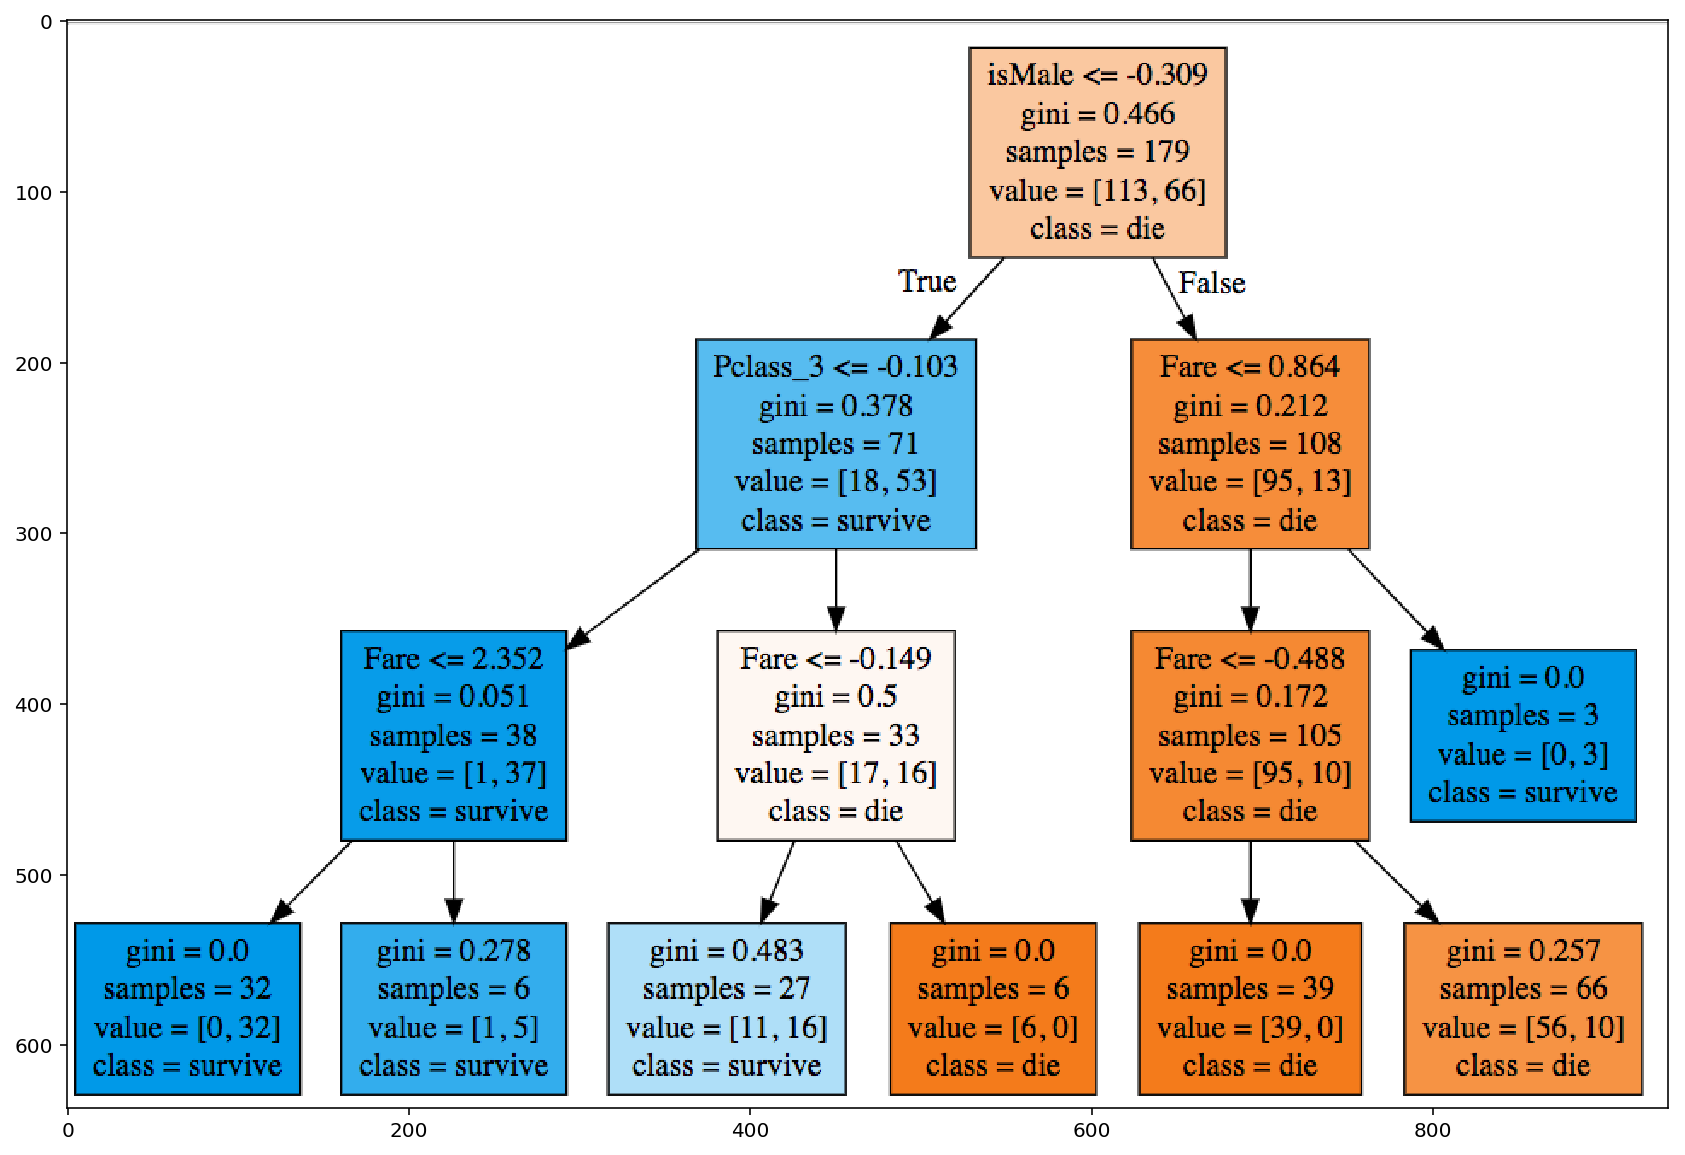

In [1051]:
# Дерево решений
image = imread('Decision Tree Titanic.png')
pylab.imshow(image)

([<matplotlib.axis.YTick at 0x1a1d7200f0>,
 <a list of 11 Text yticklabel objects>)

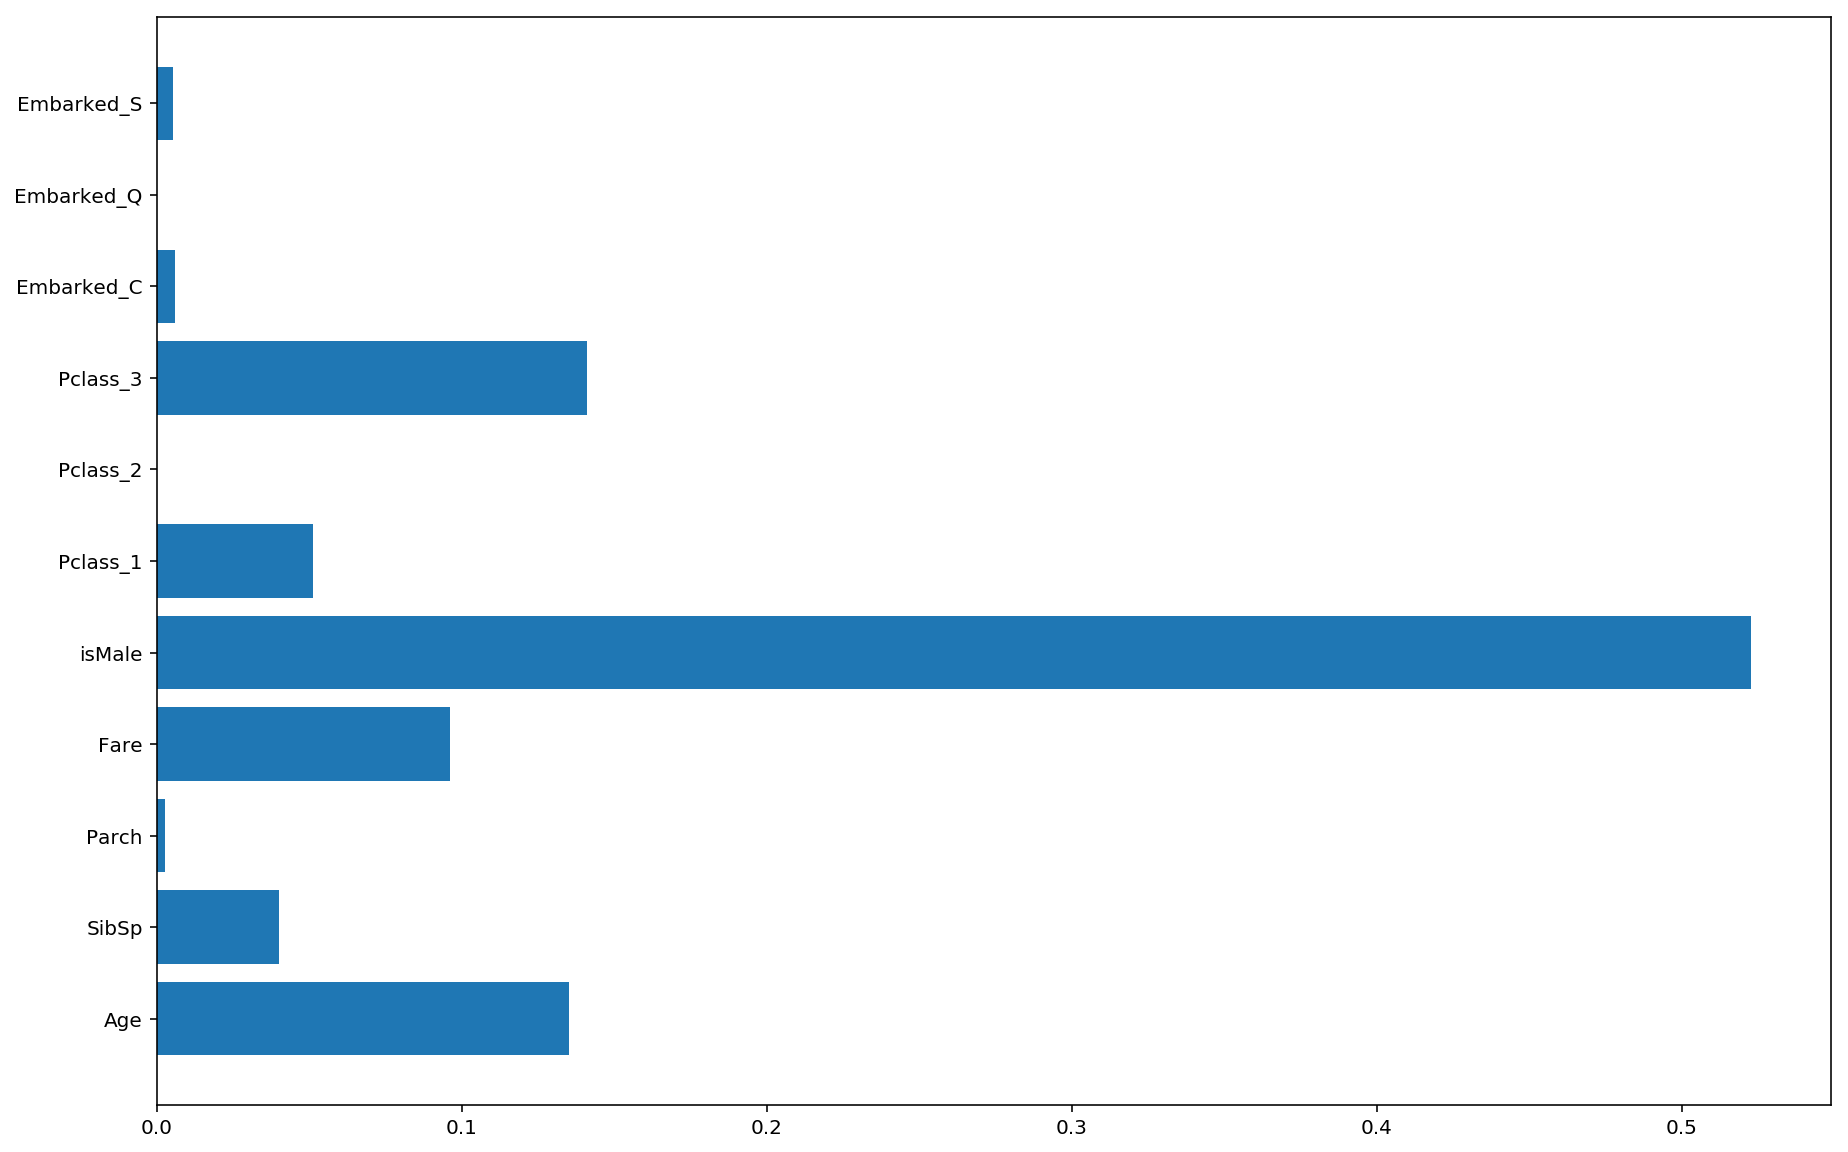

In [1052]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X_val.columns)),X_val.columns)